# Text based
- add label to text
- set anchor text
- cosine similarity
- cross validation/AUC

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

## Gentrified Texts

In [2]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled_25.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

## joined the structual data as well

In [3]:
stru_data = pd.read_csv("data/all_stru_data.csv")

In [4]:
print(lsoa_label.columns)

Index(['LSOA code', 'LSOA11NM', 'imd_score_', 'price_grow', 'high_price',
       'high_imd_i', 'gentrified', 'geometry'],
      dtype='object')


In [5]:
stru_data = stru_data.rename(columns={'LSOA Code': 'LSOA code'})
lsoa_label = lsoa_label.merge(stru_data, on= "LSOA code", how="left")

In [6]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [7]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()
text_valid["geometry"] = text_valid["wgs84_polygon.coordinates"].apply(lambda coords: Polygon(coords[0]))
# creat GeoDataFrame， set WGS84 coordinate
gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [8]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [9]:
joined = gpd.sjoin(gdf_27700, lsoa_label[["geometry", "gentrified", "pop_growth_rate", 
                                          "avg_den", "senior_per", "minority_per"]], 
                                          how="left", predicate="within")

In [10]:
print("the percentage of texts being labeled:", joined['gentrified'].notna().mean())

the percentage of texts being labeled: 0.8842856683494646


In [11]:
# check the texts
print("total texts:", len(gdf_27700))
print("text within lsoa:", joined['gentrified'].notna().sum())

total texts: 155495
text within lsoa: 137502


Geometry seems fine, and not all texts are within lsoas, meaning some text polygon cross over more than one lsoas.

Solutions: use the centroid geometry for label

In [12]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [13]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["geometry", "gentrified", "pop_growth_rate", 
                                                                            "avg_den", "senior_per", "minority_per"]],
                                                                            how="left",predicate="within")

In [14]:
# check the texts again
print("total texts:", len(gdf_27700))
print("text within lsoa:", joined_centroid['gentrified'].notna().sum())

total texts: 155495
text within lsoa: 155367


There's still 128 left, meaning it might happened to be on the boundary of lsoas.

Remove

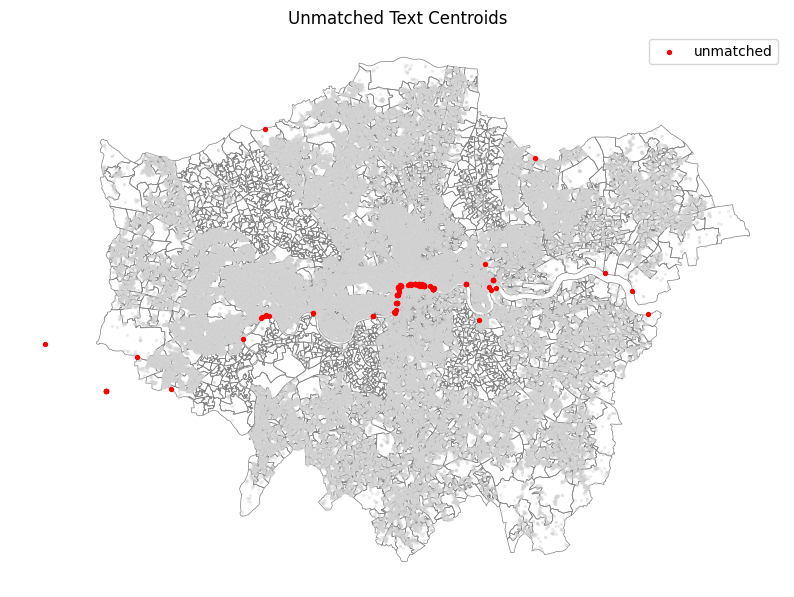

In [15]:
import matplotlib.pyplot as plt

# map the unlabelled points
unmatched = joined_centroid[joined_centroid["gentrified"].isna()]
fig, ax = plt.subplots(figsize=(10, 10))
lsoa_label.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5)
gdf_27700.set_geometry("centroid").plot(ax=ax, color="lightgray", markersize=2, alpha=0.3)
unmatched.set_geometry("centroid").plot(ax=ax, color="red", markersize=8, label="unmatched")


plt.legend()
plt.title("Unmatched Text Centroids")
plt.axis("off")
plt.show()


In [16]:
joined_cleaned = joined_centroid[joined_centroid["gentrified"].notna()].copy()

In [17]:
joined_cleaned.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_382', 'sbert_383', 'geometry', 'centroid', 'index_right',
       'gentrified', 'pop_growth_rate', 'avg_den', 'senior_per',
       'minority_per'],
      dtype='object', length=409)

In [18]:
# convert the SBERT list vectors into numpy arrays 
# select all SBERT columns
sbert_cols = [col for col in joined_cleaned.columns if col.startswith("sbert_")]

# combine these columns into a matrix X (with N rows and 384 columns)
X = joined_cleaned[sbert_cols].values 
y = joined_cleaned["gentrified"].astype(int).values

# set train/test, stratify to ensure similar label distribution in the train/test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# initialize the model and handle the imbalance using class_weight
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# prediction and evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     29373
           1       0.09      0.60      0.16      1701

    accuracy                           0.66     31074
   macro avg       0.53      0.63      0.48     31074
weighted avg       0.92      0.66      0.75     31074

AUC Score: 0.6847687109340856


The model has some predicting capabilities (with an AUC value slightly over 0.6), but its ability to predict gentrified = 1 is still insufficient.

## Anchor texts

1. set anchor text, using sbert to encode them

2. perform similarity calculation for each text


In [19]:
# anchor and encode
# add another typr here: transport/infrusturcture
anchor_dict = {
    "residential": "flat conversion, refurbishment, luxury dwelling",
    "commercial": "coffee shop, gallery, retail unit upgrade",
    "green": "park improvement, landscaping, tree planting",
    "cultural": "artist studios, cultural space, gallery conversion",
    "infrustructure": "station, lighting enhancement, utilities upgrade" 
}
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
anchor_vecs = {k: sbert_model.encode(v) for k, v in anchor_dict.items()}

this step might take a few hours

In [20]:
# def iterate_anchor_update(sentences, anchor_vecs, sbert_model, topk=20, max_iter=10, tol=1e-4):
    
#     prev_anchor_vecs = {k: v.copy() for k, v in anchor_vecs.items()}
#     all_sentences = [sent for sent_list in sentences for sent in sent_list]
#     all_sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

#     for iteration in range(max_iter):
#         print(f"\n🔁 Iteration {iteration + 1}")
#         updated_vecs = {}
#         total_shift = 0.0
        
#         for cat in tqdm(anchor_vecs, desc="Updating anchors"):
#             sims = cosine_similarity([anchor_vecs[cat]], all_sent_vecs)[0]
#             top_idx = np.argsort(sims)[-topk:][::-1]
#             top_sent_vecs = all_sent_vecs[top_idx]
#             new_vec = np.mean(top_sent_vecs, axis=0)
            
#             shift = np.linalg.norm(new_vec - anchor_vecs[cat])
#             total_shift += shift
#             updated_vecs[cat] = new_vec
        
#         print(f"🔍 Mean anchor shift: {total_shift / len(anchor_vecs):.6f}")
        
#         # Check convergence
#         if total_shift / len(anchor_vecs) < tol:
#             print("✅ Converged.")
#             break
        
#         anchor_vecs = updated_vecs

#     return anchor_vecs

In [21]:
# updated_anchor_vecs = iterate_anchor_update(
#     sentences=joined_cleaned['sentences'],
#     anchor_vecs=anchor_vecs,
#     sbert_model=sbert_model,
#     topk=20,
#     max_iter=10,
#     tol=1e-4
# )

In [22]:
# def extract_topk_sentences_per_anchor(anchor_vecs, all_sentences, sbert_model, topk=10):
#     """
#     返回每个 anchor 类别对应的 top-k 最相关句子
#     """
#     print(f"\n Extracting top-{topk} sentences per anchor...")

#     sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

#     anchor_top_sentences = {}

#     for cat, anchor_vec in anchor_vecs.items():
#         sims = cosine_similarity([anchor_vec], sent_vecs)[0]
#         sorted_idx = np.argsort(sims)[::-1]  # 从大到小

#         seen = set()
#         top_sents = []

#         for i in sorted_idx:
#             sent = all_sentences[i]
#             if sent not in seen:
#                 seen.add(sent)
#                 top_sents.append(sent)
#             if len(top_sents) >= topk:
#                 break

#         anchor_top_sentences[cat] = top_sents

#     return anchor_top_sentences

In [23]:
# # 所有句子展开
# all_sents = [sent for sent_list in joined_cleaned['sentences'] for sent in sent_list]

# # 提取每个 anchor 类别的 top-k 相似句
# top_sents_per_anchor = extract_topk_sentences_per_anchor(
#     anchor_vecs=updated_anchor_vecs,
#     all_sentences=all_sents,
#     sbert_model=sbert_model,
#     topk=10  # 可设成 20、50 等

In [24]:
# for cat, sents in top_sents_per_anchor.items():
#     print(f"\n=== {cat} ===")
#     for i, sent in enumerate(sents, 1):
#         print(f"{i}. {sent}")

using the topk to select the keylines we can see there're a lot of familiar sentences with slightly differences, which means their embedding were almost the same with sebrt, but this reuslts isn't very useful.

we can see the sentences are still very similar with each other so we try to use sim_threshold to control the meanings.

In [25]:
def extract_diverse_anchor_sentences(
    anchor_vecs,           # 你的人工定义 anchor 向量: {anchor_name: vector}
    all_sentences,         # 句子列表: List[str]
    sbert_model,           # SentenceTransformer 模型
    topk=50,               # 每个 anchor 最多考虑 topk 相似句子作为候选
    anchor_threshold=0.5,  # anchor 与句子相似度下限
    sim_threshold=0.75     # 被选句子之间最大相似度（越小越多样）
):
    # 编码所有句子为向量
    print("emcoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    anchor_top_sentences = {}

    for cat, anchor_vec in tqdm(anchor_vecs.items(), desc="🔍 extract sentences from each category"):
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]

        # 找出相似度高于 anchor_threshold 的 topk 句子
        sorted_idx = np.argsort(sims)[::-1]
        filtered_idx = [i for i in sorted_idx if sims[i] >= anchor_threshold][:topk]

        selected = []
        selected_vecs = []

        for i in filtered_idx:
            sent = all_sentences[i]
            vec = sent_vecs[i]

            # 判断与已选句子的相似度是否都低于 sim_threshold
            if all(cosine_similarity([vec], [v])[0][0] < sim_threshold for v in selected_vecs):
                selected.append({"sentence": sent, "score": float(sims[i])})
                selected_vecs.append(vec)

        anchor_top_sentences[cat] = selected
        print(f"✅ {cat}: select {len(selected)} sentences")

    return anchor_top_sentences

In [26]:
df_label_sentences = joined_cleaned.reset_index(drop=True)
df_label_sentences['sentence_id'] = joined_cleaned.index

all_sentences = joined_cleaned['sentences'].apply(
    lambda x: str(x[0]) if isinstance(x, np.ndarray) and len(x) > 0 else str(x)
).tolist()

In [55]:
diverse_results = extract_diverse_anchor_sentences(
    anchor_vecs=anchor_vecs,            # original anchor text
    all_sentences=all_sentences,
    sbert_model=sbert_model,            # SBERT
    topk=50,                            # only comsider the most 50 similar sentences
    anchor_threshold=0.55,               # silimarity with anchor
    sim_threshold=0.75                  # similarity between sentences
)

emcoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

🔍 extract sentences from each category:  20%|██        | 1/5 [00:00<00:01,  3.91it/s]

✅ residential: select 5 sentences


🔍 extract sentences from each category:  40%|████      | 2/5 [00:00<00:00,  3.21it/s]

✅ commercial: select 11 sentences


🔍 extract sentences from each category:  60%|██████    | 3/5 [00:00<00:00,  3.41it/s]

✅ green: select 11 sentences
✅ cultural: select 8 sentences


🔍 extract sentences from each category: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

✅ infrustructure: select 26 sentences


In [56]:
for i, item in enumerate(diverse_results["residential"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Refurbishment and extension of single family dwelling.  (similarity: 0.78)
2. Retrospective application for conversion of single dwelling to 2 x 2 bedroom flats  (similarity: 0.74)
3. Internal alterations and refurbishment of flat.  (similarity: 0.72)
4. Conversion of existing outbuilding to residential flat.  (similarity: 0.72)
5. Change of use from three flats into a single house  (similarity: 0.71)


In [57]:
for i, item in enumerate(diverse_results["commercial"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Change of use to (A3) coffee shop with replacement shop front and rear seating area.  (similarity: 0.71)
2. Fit out of vacant retail unit into coffee shop; retention of heritage shop front with new signage; replacement of door and window set to garden with increased door width; reconfigured basement layout with increase in width of opening between rooms; installation of small service lift between floors; installation of recessed lighting throughout; new electrical installations and new HVAC installations  (similarity: 0.63)
3. Single storey rear extension for use as storage and preparation area, ancillary space to existing coffee shop; and associated alterations  (similarity: 0.63)
4. Use as book shop/ art shop and coffee bar (A1 Use Class)  (similarity: 0.62)
5. Installation of mezzanine floor space including provision of coffee shop in Unit 10.  (similarity: 0.61)
6. Retrospective installation of a new shopfront  (similarity: 0.60)
7. Renovation of existing Starbucks store in the 

In [58]:
for i, item in enumerate(diverse_results["green"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Removal of tree and works to landscape of front garden  (similarity: 0.74)
2. Alterations to front garden landscaping  (similarity: 0.73)
3. Proposed landscaping improvement works including surface water flood mitigation using new rain gardens, reshaping of existing bund, new tree planting and new car park spaces with associated works  (similarity: 0.71)
4. Works to trees within Conservation Area being, pruning of two Silver Birch trees in front garden.  (similarity: 0.70)
5. Works to prune various trees subject to a Tree Preservation Order  (similarity: 0.69)
6. Works to trees under Tree Preservation Order 43: G2 - Cut back trees, hedges and vegetation along the boundary with Fairways  (similarity: 0.69)
7. Tree works in Tufnell park conservation area.  (similarity: 0.68)
8. Tree works in the Whitehall Park conservation area.  (similarity: 0.68)
9. Tree works in Highbury Fields conservation area: 1 x Prunus cerasifera in rear garden: Reduce crown to previous reduction points 1 x Tr

In [59]:
for i, item in enumerate(diverse_results["cultural"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Erection of a 5 storey building to provide ground floor community space and artists workspace and 12 dwellings above dedicated for artists.  (similarity: 0.60)
2. Change of use of art gallery (Class D1) to offices (Class B1a)  (similarity: 0.60)
3. Reconfiguration of the Great Chamber and Ante-Room as a portrait gallery and interpretation, redecoration, new floor and wall finishes, reservicing and relighting.  (similarity: 0.58)
4. Installation of Community artwork.  (similarity: 0.58)
5. Change of use of shop/service/art gallery (A1/A2/D1) on ground floor to bespoke tattoo and gallery workshop space (Sui Generis).  (similarity: 0.58)
6. Temporary Meanwhile Project on the North of the main Foundation site, comprising artist studios, community facilities with cafe, community office and open air cinema.  (similarity: 0.57)
7. Erection of an annexe extension with Art studios and store areas to existing Adult & Community Education Centre  (similarity: 0.56)
8. Interior alterations to ex

In [60]:
for i, item in enumerate(diverse_results["infrustructure"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Installation of lighting to the facade at high level.  (similarity: 0.64)
2. Replacement and upgrading of lamps and holders of existing floodlights  (similarity: 0.63)
3. Upgrade of telecommunication apparatus and associated works.  (similarity: 0.63)
4. Replacement of heritage lighting heads to the existing platform lighting at Hanwell Railway Station  (similarity: 0.62)
5. Upgrade of telecoms base station  (similarity: 0.62)
6. Installation of a lighting scheme comprising 71 luminaire fittings on the principal external elevation of Fenchurch Street Station.  (similarity: 0.61)
7. Replacement of all existing lamps that light parts of the station used by passengers (including station forecourts, platforms and car parks) with commissioned and operational new LED lighting (Listed Building Consent)  (similarity: 0.61)
8. Installation of new wall lights and building lighting to replace existing.  (similarity: 0.61)
9. REPLACEMENT OF ELECTRICAL SUB-STATION  (similarity: 0.61)
10. Public 

In [61]:
def get_anchor_vecs_from_diverse_results(diverse_results, sbert_model):
    anchor_vecs = {}
    for cat, items in diverse_results.items():
        sentences = [entry["sentence"] for entry in items]
        vecs = sbert_model.encode(sentences, batch_size=32)
        anchor_vecs[cat] = vecs.mean(axis=0)  # 平均向量作为 anchor
    return anchor_vecs

In [62]:
# 获取平均向量组成的 anchor
keyline_vecs = get_anchor_vecs_from_diverse_results(diverse_results, sbert_model)

In [63]:
def score_sentences_against_anchors(anchor_vecs, all_sentences, sbert_model):
    
    print("encoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    scores = {}

    for cat, anchor_vec in anchor_vecs.items():
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]  # shape: (num_sentences,)
        scores[cat] = sims

    # 合成 DataFrame
    import pandas as pd
    score_df = pd.DataFrame(scores)
    score_df['sentence'] = all_sentences

    return score_df

In [64]:
# 调用函数
score_df = score_sentences_against_anchors(
    anchor_vecs=keyline_vecs,
    all_sentences=all_sentences,
    sbert_model=sbert_model
)

encoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

In [65]:
score_df['sentence_id'] = df_label_sentences['sentence_id'].values

In [66]:
print(score_df.columns)
print(df_label_sentences.columns)

Index(['residential', 'commercial', 'green', 'cultural', 'infrustructure',
       'sentence', 'sentence_id'],
      dtype='object')
Index(['sentence', 'gentrified', 'centroid', 'geometry', 'sentence_id',
       'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per'],
      dtype='object')


In [68]:
columns_to_keep = ['gentrified', 'centroid', 'geometry', 
                   'sentence_id', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per']
df_label_sentences = df_label_sentences[columns_to_keep]
print(df_label_sentences.head(5))

  gentrified                       centroid  \
0      False  POINT (530683.381 183923.221)   
1      False  POINT (529227.885 186433.184)   
2      False  POINT (524395.034 188042.162)   
3      False  POINT (514266.796 180237.645)   
4      False   POINT (531611.885 176937.74)   

                                            geometry  sentence_id  \
0  POLYGON ((530675.692 183924.893, 530679.985 18...            0   
1  POLYGON ((529221.785 186434.442, 529221.729 18...            1   
2  POLYGON ((524379.669 188032.215, 524385.763 18...            2   
3  POLYGON ((514259.741 180239.015, 514262.976 18...            3   
4  POLYGON ((531616.952 176934.641, 531611.165 17...            4   

   pop_growth_rate       avg_den  senior_per  minority_per  
0         0.073130  16340.515284    8.472850     17.550059  
1         0.006618  12654.580134    9.399077     32.164531  
2         0.054458  13904.333986   15.202991     26.777125  
3        -0.014105   1436.788216   11.295069     78.793903

In [69]:
df_label_sentences = df_label_sentences.rename(columns={'sentences': 'sentence'})

In [70]:
df_sentence = df_label_sentences.merge(score_df, on='sentence_id', how='left')
print(df_sentence.columns)

Index(['gentrified', 'centroid', 'geometry', 'sentence_id', 'pop_growth_rate',
       'avg_den', 'senior_per', 'minority_per', 'residential', 'commercial',
       'green', 'cultural', 'infrustructure', 'sentence'],
      dtype='object')


# Predicting/XGBoosts

In [71]:
# true 1， false 0
df_sentence['gentrified'] = df_sentence['gentrified'].astype(int)

In [72]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 特征选择
feature_cols_all = [
    'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
    'residential', 'commercial', 'green', 'cultural', 'infrustructure'
]

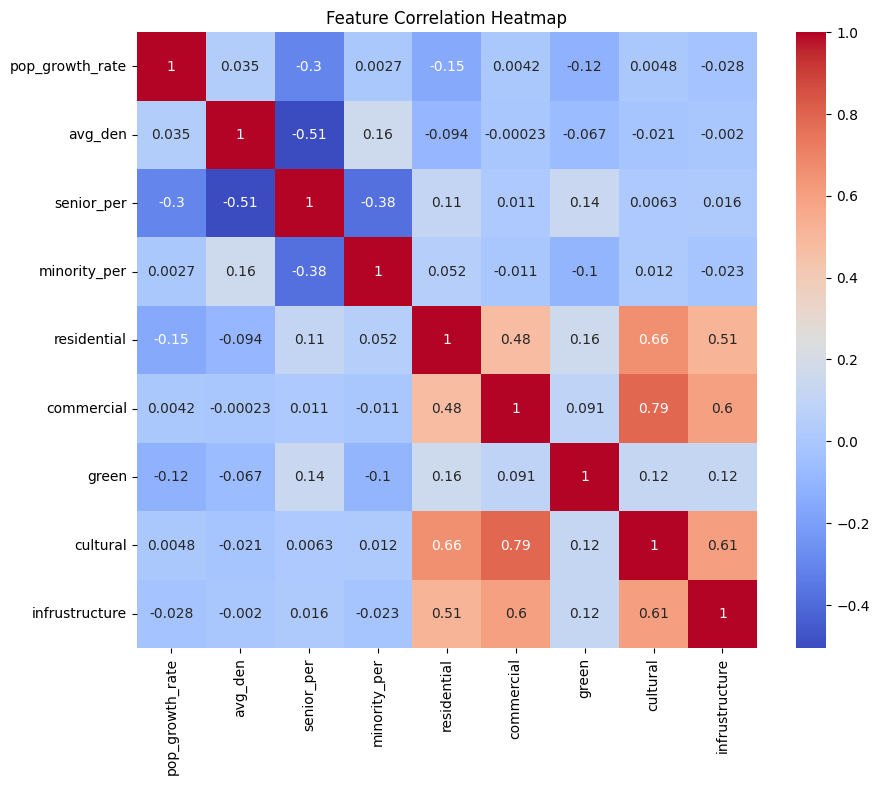

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df_sentence[feature_cols_all].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_for_vif = df_sentence[feature_cols_all]
vif_data = pd.DataFrame()
vif_data["feature"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

print(vif_data)

           feature        VIF
0  pop_growth_rate   1.215360
1          avg_den   3.356519
2       senior_per   5.703861
3     minority_per   4.115529
4      residential  18.112066
5       commercial  20.152701
6            green   5.637843
7         cultural  36.730359
8   infrustructure  17.233420


In [111]:
feature_cols = [
    'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
    'residential', 'commercial', 'green', 'cultural', 'infrustructure'
]

X = df_sentence[feature_cols]
y = df_sentence['gentrified']  # 0 / 1

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 计算样本数
true = df_sentence['gentrified'].sum()             # 正例数量（True）
false = len(df_sentence) - true                      # 负例数量（False）

# 计算权重
scale_pos_weight = false / true

# 模型训练
model = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# 预测 & 评估
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29373
           1       0.96      1.00      0.98      1701

    accuracy                           1.00     31074
   macro avg       0.98      1.00      0.99     31074
weighted avg       1.00      1.00      1.00     31074



In [78]:
from sklearn.metrics import classification_report

# train performance
y_train_pred = model.predict(X_train)
print("train:")
print(classification_report(y_train, y_train_pred))

# test performance
y_test_pred = model.predict(X_test)
print("test:")
print(classification_report(y_test, y_test_pred))

train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117491
           1       0.97      1.00      0.98      6802

    accuracy                           1.00    124293
   macro avg       0.99      1.00      0.99    124293
weighted avg       1.00      1.00      1.00    124293

test:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29373
           1       0.97      0.99      0.98      1701

    accuracy                           1.00     31074
   macro avg       0.98      1.00      0.99     31074
weighted avg       1.00      1.00      1.00     31074



In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print("F1 cross-val mean:", np.mean(scores))

F1 cross-val mean: 0.9661500447625485


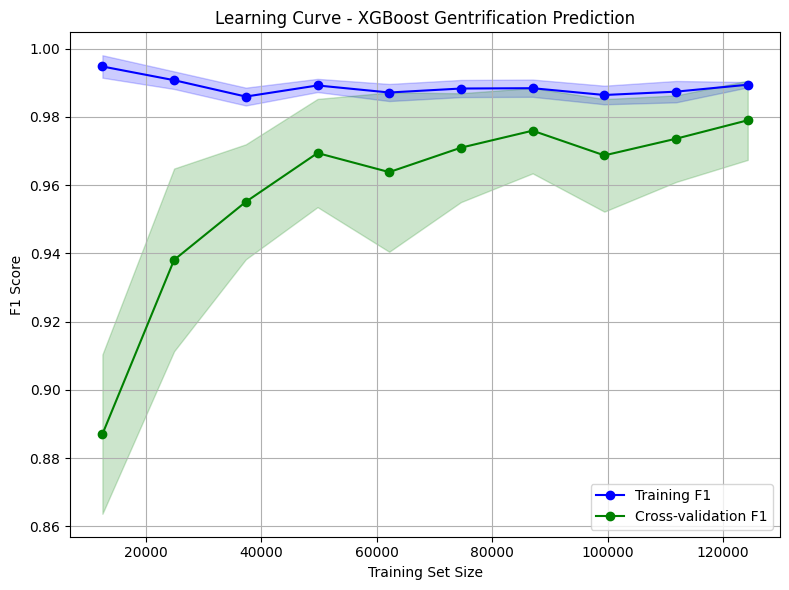

In [ ]:
# learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 画图
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training F1')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation F1')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve - XGBoost Gentrification Prediction')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

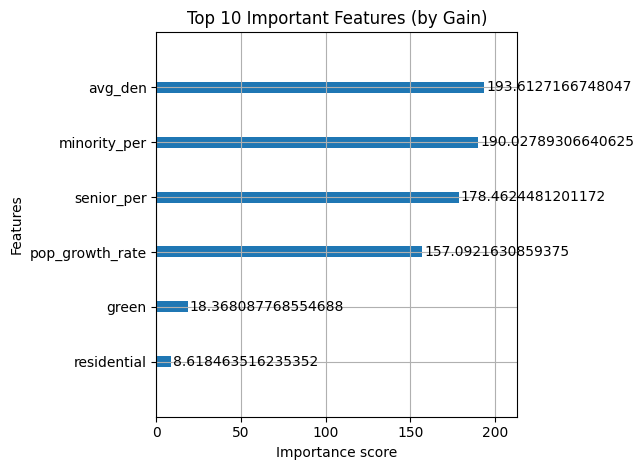

In [81]:
# feature importance
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Important Features (by Gain)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
X_semantic = df_sentence[['residential', 'commercial', 'green', 'cultural', 'infrustructure']]
y_semantic = df_sentence['gentrified']

# 拆分训练集和测试集
X_semantic_train, X_semantic_test, y_semantic_train, y_semantic_test = train_test_split(
    X_semantic, y_semantic, stratify=y_semantic, test_size=0.2, random_state=42
)

# 计算样本数
true = df_sentence['gentrified'].sum()             # 正例数量（True）
false = len(df_sentence) - true                      # 负例数量（False）

# 计算权重
scale_pos_weight = false / true

# 模型训练
model_semantic = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
model_semantic.fit(X_semantic_train, y_semantic_train)

# 预测 & 评估
y_semantic_pred = model_semantic.predict(X_semantic_test)
print(classification_report(y_semantic_test, y_semantic_pred))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     29373
           1       0.08      0.43      0.14      1701

    accuracy                           0.71     31074
   macro avg       0.52      0.58      0.48     31074
weighted avg       0.91      0.71      0.79     31074



In [97]:
f1_scores = cross_val_score(model_semantic, X_semantic, y, cv=5, scoring='f1')
print("F1 Score (only semantic features):", np.mean(f1_scores))

F1 Score (only semantic features): 0.13076704106215922


In [ ]:
# Undersampling

from sklearn.utils import resample

# separate
df_0 = df_sentence[df_sentence['gentrified'] == 0]
df_1 = df_sentence[df_sentence['gentrified'] == 1]

# Random downsampling of class 0
df_0_down = resample(df_0, replace=False, n_samples=len(df_1), random_state=42)

# merge
df_balanced = pd.concat([df_0_down, df_1])

In [104]:
X_bal = df_balanced[['residential', 'commercial', 'green', 'cultural', 'infrustructure']]
y_bal = df_balanced['gentrified']

# 拆分训练集和测试集
X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(
    X_bal, y_bal, stratify=y_bal, test_size=0.2, random_state=42
)

# 计算样本数
true2 = df_balanced['gentrified'].sum()             # 正例数量（True）
false2 = len(df_balanced) - true                      # 负例数量（False）

# 计算权重
scale_pos_weight = false2 / true2

# 模型训练
model_balanced = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
model_balanced.fit(X_bal_train, y_bal_train)

# 预测 & 评估
y_bal_pred = model_balanced.predict(X_bal_test)
print(classification_report(y_bal_test, y_bal_pred))

              precision    recall  f1-score   support

           0       0.57      0.58      0.57      1701
           1       0.57      0.57      0.57      1701

    accuracy                           0.57      3402
   macro avg       0.57      0.57      0.57      3402
weighted avg       0.57      0.57      0.57      3402



In [105]:
f1_scores = cross_val_score(model_balanced, X_bal, y_bal, cv=5, scoring='f1')
print("F1 Score (only semantic features):", np.mean(f1_scores))

F1 Score (only semantic features): 0.5647847998989026


<Figure size 1000x600 with 0 Axes>

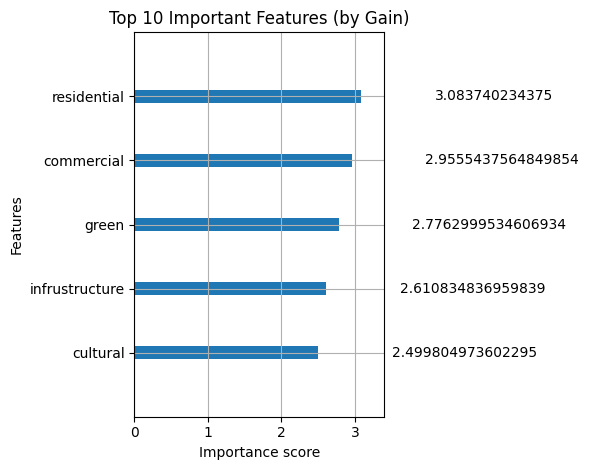

In [106]:
# feature importance
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model_balanced, importance_type='gain', max_num_features=10)
plt.title("Top 10 Important Features (by Gain)")
plt.grid(True)
plt.tight_layout()
plt.show()

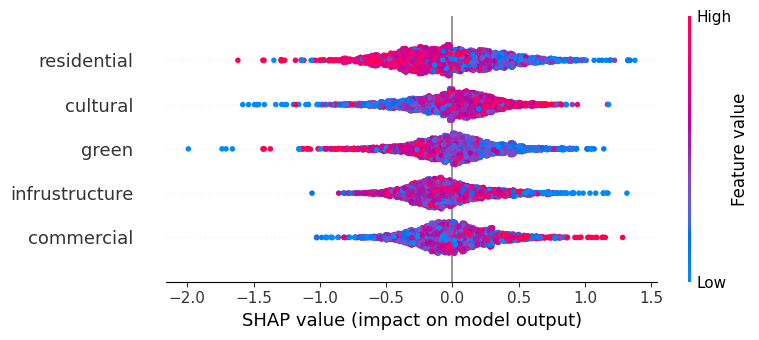

In [107]:
import shap

explainer = shap.Explainer(model_balanced, X_bal_train)
# 对测试集进行解释
shap_values = explainer(X_bal_test)
shap.summary_plot(shap_values, X_bal_test)


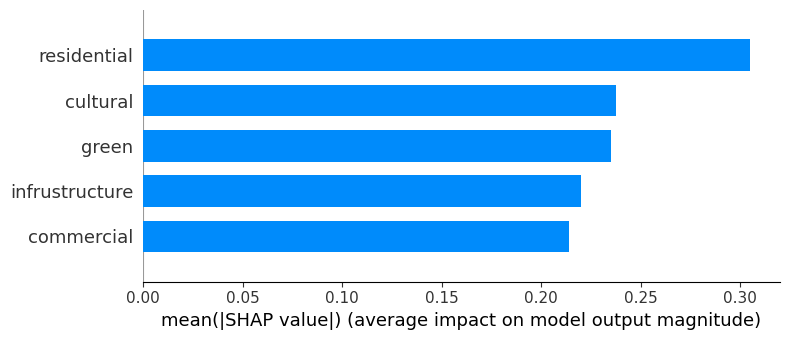

In [108]:
shap.summary_plot(shap_values, X_bal_test, plot_type="bar")